<a href="https://colab.research.google.com/github/JaxonOShea/Recommender-Projects/blob/main/Recommender_Basic_Ranking_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender Model: Ranking

In the digital age, helping users discover new artists they’ll love is essential for music platforms. A recommender system enhances this experience by using collaborative filtering to rank artists from a pool generated by a retrieval model. This approach analyses user interactions and preferences to identify patterns and similarities. By examining the behavior of users with similar tastes, the system can prioritize artists that are likely to appeal to each individual user, ensuring that the most appealing and engaging artists are presented first. This personalized ranking boosts user satisfaction and engagement.

---

**Table of Contents**

1. Data Wrangling and Preparation <br>
  1.1 Loading Data <br>
  1.2 Cleaning and Wrangling of Plays DF <br>
  1.3 Preparing the Datasets <br>
2. Ranking Model <br>
  2.1 Architecture <br>
  2.2 Loss & Metrics <br>
  2.3 Model <br>
  2.4 Fitting and Evaluating <br>
  2.5 Testing the Model <br>
3. Summary

---



0. Libraries

All the necessary libraries and packages for completing this recommender are loaded here.

In [1]:
# install tensorflow recommenders package
!pip install -q tensorflow-recommenders

In [2]:
# import required libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import tensorflow_recommenders as tfrs
from typing import Dict, Text
import matplotlib.pyplot as plt
from keras.regularizers import l2, l1

In [3]:
# load google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Data Wrangling and Preparation <br>
  Text

  1.1 Loading Data <br>

In [4]:
# define project directory and show subfolders/files
dir = "/content/drive/MyDrive/Colab Notebooks/Recommenders/02-Two_Tower_Model"

In [5]:
#Import play data to dataframe and add column names
df_plays = pd.read_csv(os.path.join(dir, '01-Data', 'usersha1-artmbid-artname-plays.tsv'), sep='\t', names=['user_code', 'artist_code', 'artist_name', 'plays'])
df_plays.head()

,user_code,artist_code,artist_name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


In [6]:
#Import user profile data to dataframe and add column names
df_users = pd.read_csv(os.path.join(dir, '01-Data', 'usersha1-profile.tsv'), sep='\t', names=['user_code', 'gender', 'age', 'country', 'signup'])
df_users.head()

,user_code,gender,age,country,signup
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


  1.2 Cleaning and Wrangling of Plays DF <br>

Before the data can be used for a recommender system, it is important to review the data and clean it. In this example we are going to check the size, number of unique entries and the number of null values.

In [7]:
# basic exploritory analysis of dataframe
print('Number of lines in dataframe:', df_plays.shape[0])
print('Number of unique users in dataframe:', df_plays['user_code'].nunique())
print('Number of unique artists in dataframe by code:', df_plays['artist_code'].nunique())
print('Number of unique artists in dataframe by name:', df_plays['artist_name'].nunique())

# checking for null values
print(df_plays.isna().sum())

Number of lines in dataframe: 17535655
Number of unique users in dataframe: 358868
Number of unique artists in dataframe by code: 160112
Number of unique artists in dataframe by name: 292363
user_code           0
artist_code    226137
artist_name       204
plays               0
dtype: int64


From the results, approximately 226,000 entries have incomplete artist information. For this tutorial only the artist_name will be used, so the entries with missing artist_code can be ignored and the one missing artist_name will be removed.

In [8]:
# remove null values from dataframe
df_plays = df_plays[df_plays['artist_name'].notna()]
df_plays.isna().sum()

user_code           0
artist_code    226135
artist_name         0
plays               0
dtype: int64

In [9]:
df_plays = df_plays[['user_code', 'artist_name', 'plays']]
df_plays.head()

,user_code,artist_name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


1.3 Preparing the Datasets

Now that the dataframes are cleaned, it is needed to convert them to tensorflow datasets and prepare the additional datasets that are required to create the embeddings.

In [10]:
# convert dataframe to tensor dataset
plays_tf = tf.data.Dataset.from_tensor_slices(df_plays.to_dict('list'))

In [11]:
# remap the dictionaries to ensure the keys are correct and consistent
plays_tf = plays_tf.map(lambda x:{
    'user_code': x['user_code'],
    'artist_name': x['artist_name'],
    'plays': x['plays']
})

Shuffle the data and create test, validation and test data sets

In [12]:
tf.random.set_seed(42)
shuffled = plays_tf.shuffle(100000, seed=42, reshuffle_each_iteration=False)

# split the data into train and test
train_shuffled = shuffled.take(80000)
val_shuffled = shuffled.skip(80000).take(10000)
test_shuffled = shuffled.skip(90000).take(10000)

cached_train = train_shuffled.batch(2056).cache()
cached_val = val_shuffled.batch(2056).cache()
cached_test = test_shuffled.batch(2056).cache()

In [13]:
# create unique user and artist datasets
users = plays_tf.batch(2056).map(lambda x: x['user_code'])
artists = plays_tf.batch(2056).map(lambda x: x['artist_name'])

unique_users = np.unique(np.concatenate(list(users)))
unique_artists = np.unique(np.concatenate(list(artists)))



---



2. Ranking Model <br>

The query model, or listener model, is built from the users dataframe. This dataframe has the features; gender, age, country and signup date, which will be used to create the feature embeddings.<br>

In this basic model there are only two embeddings; one for the user name feature and one for the artist name feature. Other feature used for embedding could include gender, age, genre, etc.<br>


  2.1 Architecture

In [14]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # user embeddings
    self.user_embeddings = tf.keras.Sequential([
        tf.keras.layers.StringLookup(vocabulary=unique_users, mask_token=None),
        tf.keras.layers.Embedding(len(unique_users) + 1, embedding_dimension)
    ])

    # artist embeddings
    self.artist_embeddings = tf.keras.Sequential([
        tf.keras.layers.StringLookup(vocabulary=unique_artists, mask_token=None),
        tf.keras.layers.Embedding(len(unique_artists) +1, embedding_dimension)
     ])

    # compute predictions
    self.ratings = tf.keras.Sequential([
        # neural network layers
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = l2(0.05)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer = l2(0.05)),
        tf.keras.layers.Dropout(0.5),
        # prediction layer
        tf.keras.layers.Dense(1)
    ])

  def call(self, inputs):

    user, artist = inputs

    user_embedding = self.user_embeddings(user)
    artist_embeddings = self.artist_embeddings(artist)

    return self.ratings(tf.concat([user_embedding, artist_embeddings], axis=1))

2.2 Loss and Metrics

In [15]:
task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

2.3 Model

In [16]:
class RecModel(tfrs.models.Model):
  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss = tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model((features['user_code'], features['artist_name']))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training= False) -> tf.Tensor:
    labels = features.pop('plays')

    rating_predictions = self(features)

    return self.task(labels=labels, predictions=rating_predictions)

2.4 Fitting and Evaluating

In [17]:
model = RecModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))

In [18]:
history = model.fit(cached_train, validation_data=cached_val, epochs=100)

Epoch 1/100
39/39 [==============================] - 4s 59ms/step - root_mean_squared_error: 552.6995 - loss: 302932.9453 - regularization_loss: 3.7415 - total_loss: 302936.6887 - val_root_mean_squared_error: 633.1764 - val_loss: 186536.0469 - val_regularization_loss: 5.0078 - val_total_loss: 186541.0469
Epoch 2/100
39/39 [==============================] - 0s 8ms/step - root_mean_squared_error: 541.9521 - loss: 291053.7598 - regularization_loss: 6.8769 - total_loss: 291060.6359 - val_root_mean_squared_error: 620.3031 - val_loss: 171776.2812 - val_regularization_loss: 8.7180 - val_total_loss: 171785.0000
Epoch 3/100
39/39 [==============================] - 0s 8ms/step - root_mean_squared_error: 523.1959 - loss: 271117.5469 - regularization_loss: 10.5341 - total_loss: 271128.0812 - val_root_mean_squared_error: 605.4313 - val_loss: 155429.8750 - val_regularization_loss: 12.2279 - val_total_loss: 155442.1094
Epoch 4/100
39/39 [==============================] - 0s 7ms/step - root_mean_squar

In [19]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 2s 80ms/step - root_mean_squared_error: 483.6631 - loss: 216338.2318 - regularization_loss: 72.0796 - total_loss: 216410.3151


{'root_mean_squared_error': 483.6630859375,
 'loss': 141030.984375,
 'regularization_loss': 72.07957458496094,
 'total_loss': 141103.0625}

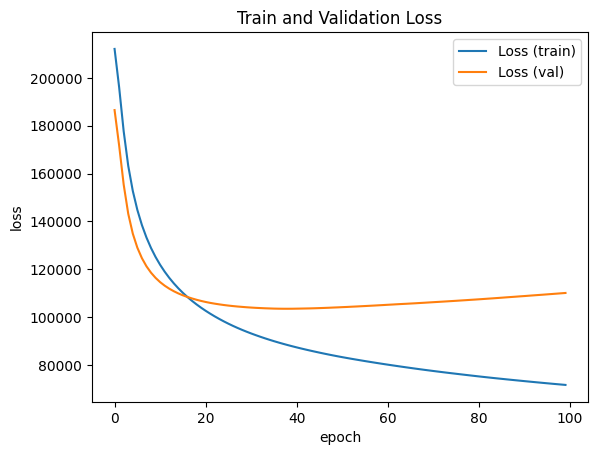

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss (train)', 'Loss (val)'], loc='upper right')
plt.show()

The graph shows that the optimal balance between training and validation loss occurs after about 40-50 epochs. Beyond this point, the validation loss begins to rise, indicating that the model is starting to overfit the training data and its performance on new, unseen data will likely degrade.

2.5 Testing the Model

The model is now trained and the results looks acceptable. To check whether the model is working correctly, it can be check against the top and bottom 10 artists of a random user.

In [21]:
# A random user's top 10 artists
df_plays.loc[df_plays['user_code'] == '00007a47085b9aab8af55f52ec8846ac479ac4fe'].head(10)

,user_code,artist_name,plays
195,00007a47085b9aab8af55f52ec8846ac479ac4fe,devendra banhart,456
196,00007a47085b9aab8af55f52ec8846ac479ac4fe,boards of canada,407
197,00007a47085b9aab8af55f52ec8846ac479ac4fe,cocorosie,386
198,00007a47085b9aab8af55f52ec8846ac479ac4fe,aphex twin,213
199,00007a47085b9aab8af55f52ec8846ac479ac4fe,animal collective,203
200,00007a47085b9aab8af55f52ec8846ac479ac4fe,atmosphere,189
201,00007a47085b9aab8af55f52ec8846ac479ac4fe,joanna newsom,184
202,00007a47085b9aab8af55f52ec8846ac479ac4fe,air,178
203,00007a47085b9aab8af55f52ec8846ac479ac4fe,portishead,162
204,00007a47085b9aab8af55f52ec8846ac479ac4fe,massive attack,149


In [22]:
# test the model's performance against a random user's top ten artist
test_ratings = {}
random_top_10 = df_plays.loc[df_plays['user_code'] == '00007a47085b9aab8af55f52ec8846ac479ac4fe'].head(10)['artist_name'].tolist()

for artist in random_top_10:
  test_ratings[artist] = model({
      'user_code': np.array(["00007a47085b9aab8af55f52ec8846ac479ac4fe"]),
      'artist_name': np.array([artist])
  })

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x:x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
boards of canada: [[191.70024]]
atmosphere: [[190.80544]]
devendra banhart: [[153.96545]]
joanna newsom: [[138.7137]]
cocorosie: [[127.395065]]
animal collective: [[121.67755]]
air: [[109.10742]]
aphex twin: [[100.615486]]
portishead: [[79.13134]]
massive attack: [[32.210876]]


In [23]:
# test the model's performance against a random user's top ten artist
test_ratings = {}
random = ['Red Hot Chili Peppers', 'Shakira','Nickelback', 'Black Eyed Peas', 'air', 'Elvis', 'Celine Dion']

for artist in random:
  test_ratings[artist] = model({
      'user_code': np.array(["00007a47085b9aab8af55f52ec8846ac479ac4fe"]),
      'artist_name': np.array([artist])
  })

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x:x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
air: [[109.10742]]
Red Hot Chili Peppers: [[24.225403]]
Shakira: [[24.225403]]
Nickelback: [[24.225403]]
Black Eyed Peas: [[24.225403]]
Elvis: [[24.225403]]
Celine Dion: [[24.225403]]



---

# 3. Summary

The trained model is working and predicting scores that are used to rank the artists. When compared to the top ten artists listened to by a random user, it shows that all ten artists are rated highly, however with some error.

However, when the model rates unknown artists, all the ratings are identical, which is a significant issue for a recommender system. The model architecture needs to be investigated to identify the cause of this error.

